The goal of this notebook is to plot the expected percent correct as a function of time for various values of:
- coherence
- stdev of diffusion

The DDM equation used is:
$$dy_t=kdt+\sigma dW_t$$

At interrogation time $t$, $y_t\sim \mathcal{N}(kt, t\sigma^2)$.
Therefore, $$P(Correct | t, k, \sigma) = 1-\Phi_{|k|t, t\sigma^2}(0)$$
This is the equation used for the plots below.

In [3]:
import matplotlib.pyplot as plt
import scipy.stats as sp
import numpy as np

In [2]:
def Phi(x,s):
    return sp.norm.cdf(0, loc=x, scale=s) # alternatively return sp.norm.cdf(-x/s)   if x>0

In [4]:
coherences = [.1,.5,1]
stdevs = [1, 2]
%matplotlib inline

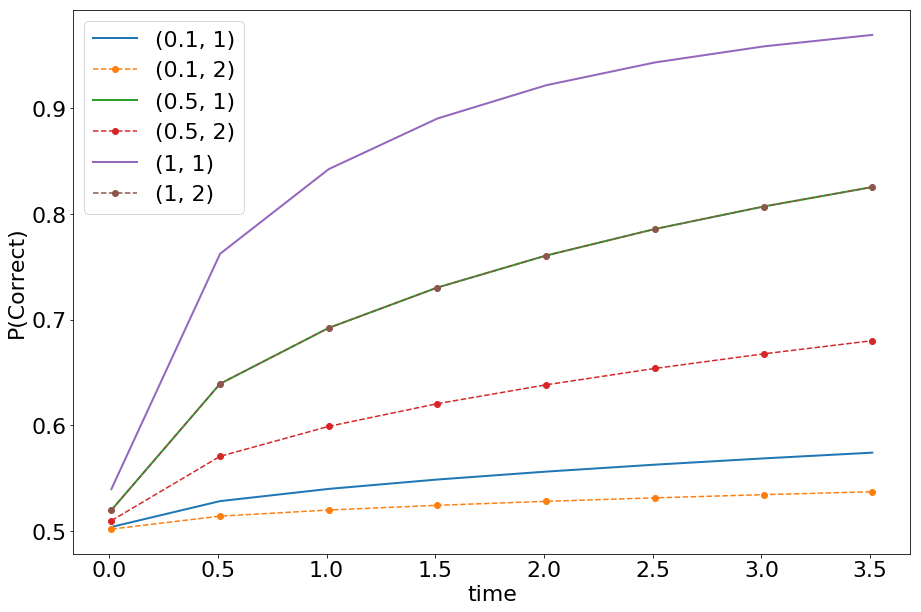

In [4]:
times = np.arange(.01, 4, .5)
fig = plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
y = {}
for c in coherences:
    for s in stdevs:
        y[(c, s)] = [1-Phi(c * t, np.sqrt(t)*s) for t in times]
        if s == 1:
            plt.plot(times, y[(c, s)], linewidth=2, label=str((c,s)))
        else:
            plt.plot(times, y[(c, s)], 'o--', label=str((c,s)))
plt.xlabel('time')
plt.ylabel('P(Correct)')
plt.legend()

It appears that some nondimentionalization is possible, whereby only $\sigma/k$ matters. This warrants some mathematical checks.

Note also that, although the bottom crves seem _linear_, by zooming out on the time axis one notices that they really still follow the same shape as the top curves. I wonder what is the mapping from one curve to the other. More precisely, I wonder whether rescaling time for each curve appropriately suffices to make them all overlap...

In [ ]:
# sanity check
k=3
s=2
a=sp.norm.cdf(0, loc=k, scale=s)
b=sp.norm.cdf(-k, loc=0, scale=s)
c=sp.norm.cdf(-k/s, loc=0, scale=1)
d=sp.norm.cdf(-k/s)
print(a, b, c, d)

I am now convinced that the previous paragraph is true. So, really, there is a single shape beneath all the curves above, up to rescaling of time.

Text(0.5, 1.0, 'standard shape')

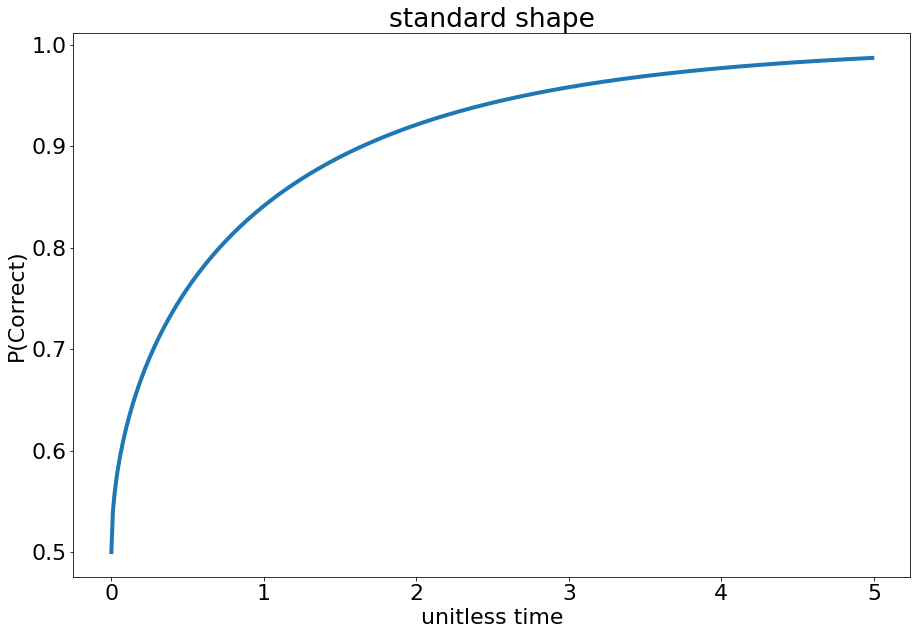

In [5]:
fig = plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
t=np.arange(0, 5, .01)
y=1-np.array([1-Phi(-np.sqrt(tt), 1) for tt in t])
plt.plot(t, y, linewidth=4)
plt.xlabel('unitless time')
plt.ylabel('P(Correct)')
plt.title('standard shape')

So, the methodology with real data on the standard dots task could be something as follows:
1. plot P(Correct) as function of VD
2. fit a curve like the one above to the data, with a single free paramater: rescaling factor of time
3. this fit gives us an estimate of $k/\sigma$.

How to estimate goodness of fit? Note that an alternative model keeps the variance fixed. It would be interesting to see which model fits the data better.

# Reset DDM model

In [5]:
def F(x, h, T, d, s):
    """
    :param x: arg to cdf
    :param h: hazard rate (must be between 0 and 1)
    :param T: time of change point
    :param d: drift term
    :param s: stdev of decision variable at time T
    """
    assert d > 0, "we don't allow negative drift for now"
    assert 0 < h < 1, "h must be a probability"
    a = np.log(((1-h)*np.exp(x) - h)/(1-h*(1+np.exp(x))))
    m = T * d
    sig = np.sqrt(T) * s
    return sp.norm.cdf((a - m )/sig)

In [59]:
xx=np.linspace(-1.3,1.3)
TT = .2
dd = 1
ss = 1
hh = .2
y = F(xx, hh, TT, dd, ss)
yx = sp.norm.cdf(xx, loc=TT*dd, scale=ss)
fit = sp.norm.cdf(xx, loc=TT*dd-.07, scale = ss/4)

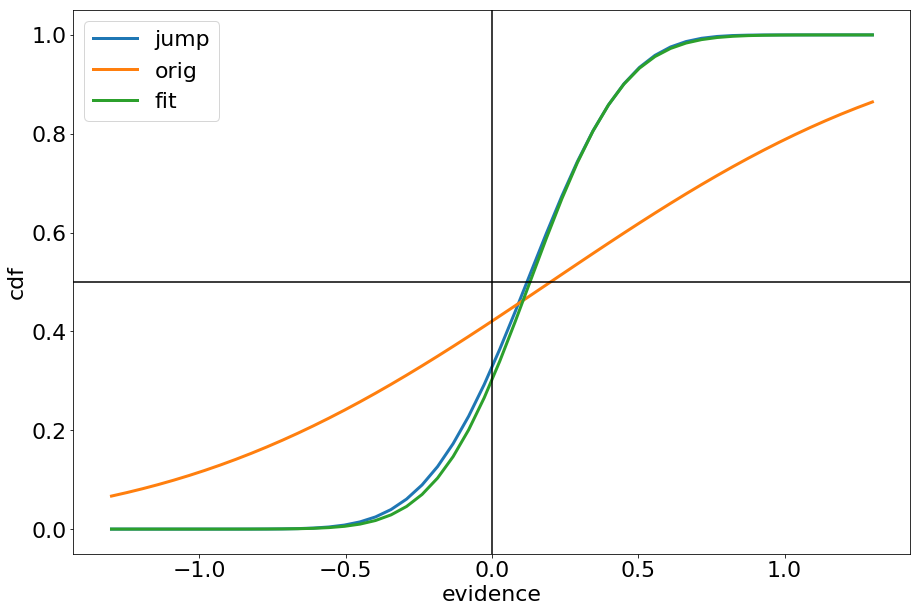

In [60]:
fig = plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
plt.plot(xx,y, xx, yx, xx, fit, linewidth=3)
plt.axhline(0.5, color='k')
plt.axvline(0, color='k')
plt.legend(['jump', 'orig','fit']);
plt.xlabel('evidence')
plt.ylabel('cdf');

In [1]:
# transformation of the arg to the cdf at jump time
def transfo(x,h):
    return np.log(((1-h)*np.exp(x) - h)/(1-h*(1+np.exp(x))))

/home/adrian/anaconda3/envs/MotionEnergy/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


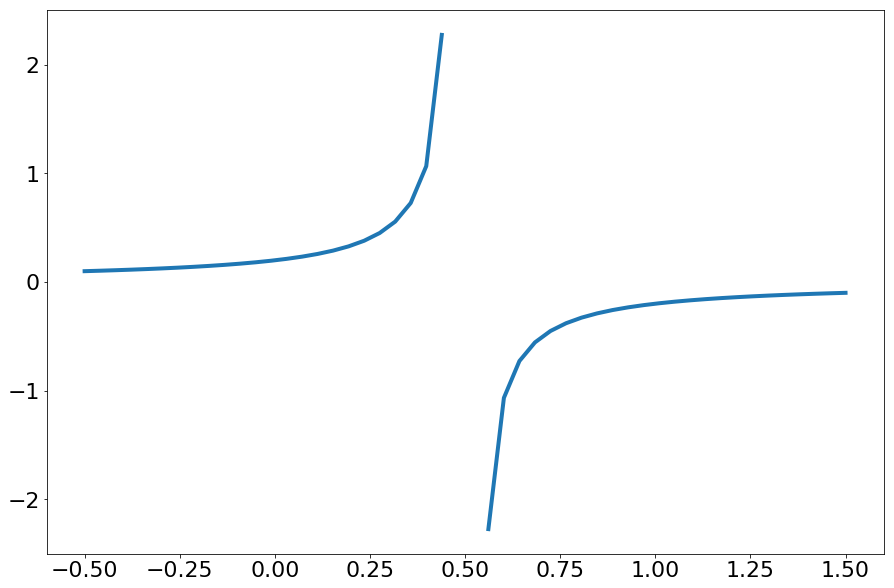

In [8]:
x=np.linspace(-.5,1.5)
y=transfo(.2,x)
fig = plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
plt.plot(x,y, linewidth=4);

Allowable region is $x>\ln\frac{h}{1-h}$.

Text(0, 0.5, 'ln(h / (1-h))')

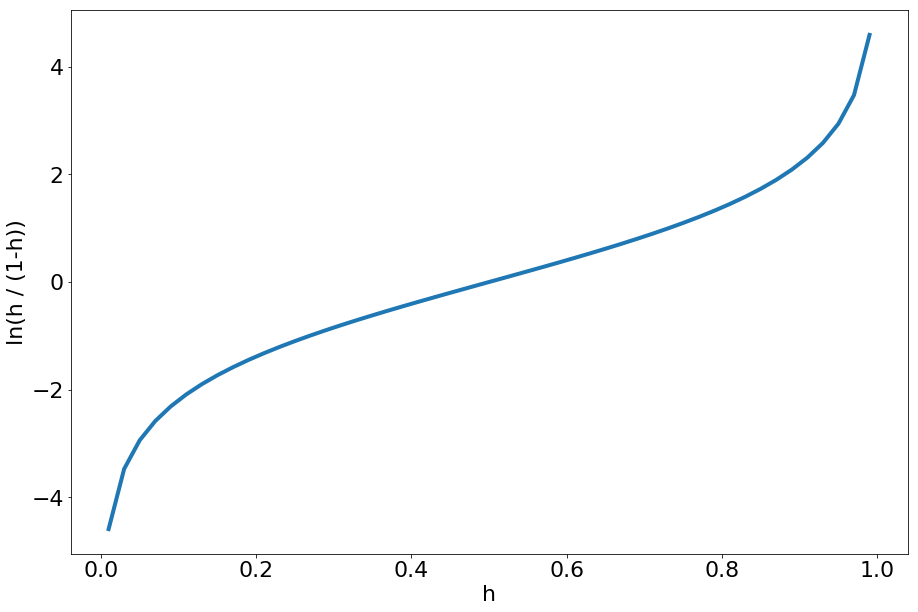

In [10]:
fig = plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})

h = np.linspace(.01,.99)
y = np.log(h / (1-h))
plt.plot(h,y, linewidth=4)
plt.xlabel('h')
plt.ylabel('ln(h / (1-h))')